In [1]:
import osmnx as ox
from leuvenmapmatching.map.inmem import InMemMap
import networkx as nx
import geopandas as gpd

In [34]:
#node = gpd.read_file('MOCT_NODE.shp')
link = gpd.read_file('MOCT_LINK.shp')

#노드자료 좌표계 변경 korea2000 -> wgs84
#node = node.to_crs({'init': 'epsg:4326'})

#링크자료 좌표계 변경 korea2000 -> wgs84
link = link.to_crs({'init': 'epsg:4326'})

In [37]:
#link에서 필요한 것만 나타내기
link = link[['LINK_ID','F_NODE','T_NODE','geometry']]

In [40]:
F_lat = []
F_lon = []
T_lat = []
T_lon = []

for i in range(0,len(link)):
    geom = link.iloc[i]['geometry']
        
    F_lat.append(geom.coords[0][1])
    F_lon.append(geom.coords[0][0])
    T_lat.append(geom.coords[-1][1])
    T_lon.append(geom.coords[-1][0])

In [42]:
link['F_lat'] = F_lat
link['F_lon'] = F_lon
link['T_lat'] = T_lat
link['T_lon'] = T_lon

In [43]:
link.head()

,LINK_ID,F_NODE,T_NODE,geometry,F_lat,F_lon,T_lat,T_lon
0,2650003819,2650001503,2650001502,"LINESTRING (128.18116 37.91388, 128.18100 37.9...",37.913883,128.181162,37.913880,128.156863
1,2650003719,2650001502,2650001503,"LINESTRING (128.15681 37.91378, 128.15696 37.9...",37.913777,128.156814,37.913786,128.181094
2,2650003817,2650001505,2650001504,"LINESTRING (128.21498 37.90477, 128.21453 37.9...",37.904770,128.214980,37.913458,128.181798
3,2650003718,2650001503,2650001504,"LINESTRING (128.18109 37.91379, 128.18113 37.9...",37.913786,128.181094,37.913364,128.181724
4,2650003818,2650001504,2650001503,"LINESTRING (128.18180 37.91346, 128.18179 37.9...",37.913458,128.181798,37.913883,128.181162


map 생성

In [44]:
map_con = InMemMap("mymap", use_latlon=True, use_rtree=True, index_edges=True)

In [46]:
for nid, row in link[['F_NODE', 'T_NODE', 'F_lat', 'F_lon', 'T_lat','T_lon']].iterrows():
    f_node = int(row['F_NODE'])
    t_node = int(row['T_NODE'])

    #add_node: f_node(시점), t_node(종점)
    map_con.add_node(f_node, (row['F_lat'], row['F_lon']))
    map_con.add_node(t_node, (row['T_lat'], row['T_lon']))
    
    #add_edge
    map_con.add_edge(f_node, t_node)

gps 데이터 가져오기

In [47]:
import pandas as pd
from rdp import rdp

In [48]:
#gps data 불러오기
gps_data = pd.read_csv('Task1_20191105.csv')

#gps데이터에서 생성시간, 위도, 경도 데이터만 나타내기
gps_data = gps_data[['003_vmcu real vehicle speed','created_on', 'latitude', 'longitude']]
gps_data.rename(columns = {'003_vmcu real vehicle speed' : 'speed'}, inplace = True)

#이상치 제거 - 위도, 경도가 0이고, 속도가 0인 것(정지상태)
gps_data = gps_data[gps_data.latitude !=0]
gps_data = gps_data[gps_data.longitude !=0]
gps_data = gps_data[gps_data.speed !="0.0mph"]

#Florian Wilhelm - Handling GPS Data with Python https://youtu.be/9Q8nEA_0ccg
route = rdp(gps_data[['latitude','longitude']].values, epsilon=1e-5)

In [49]:
#route(array 형식)를 list 형식으로 바꾸기
route_list = [tuple(x) for x in route.tolist()]

leuven map matching 적용하기

In [50]:
from leuvenmapmatching.matcher.distance import DistanceMatcher

Lowered zoom level to keep map size reasonable. (z = 10)


(None, <matplotlib.axes._subplots.AxesSubplot at 0x279c658e5c0>)

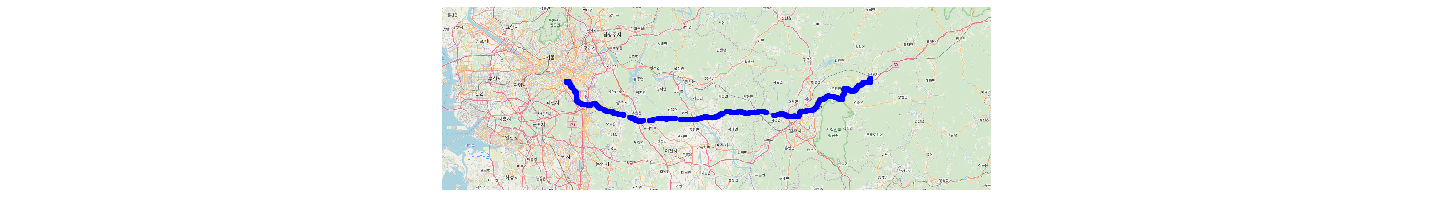

In [66]:
import leuvenmapmatching.visualization as mm_viz
matcher = DistanceMatcher(map_con,
                              max_dist_init=30, max_dist=50, min_prob_norm=0.1,
                              obs_noise=10, obs_noise_ne=20, dist_noise=10,
                              non_emitting_states=True)
states, last_idx = matcher.match(route_list)


mm_viz.plot_map(map_con, matcher=matcher, use_osm=True,
                zoom_path=True, show_graph=False, show_matching=True,
                filename=str( "map_matching.png"))